In [318]:
%reset -f

In [313]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

c = 3e18    #A * Hz
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [316]:
path = '/shares/soares-santos.physik.uzh/catalogs'
f = os.path.join(path, 'des_y3_gold.fits')

In [317]:
# gets column names
fitsio.read_header(f, ext=1)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   88 / length of dimension 1
NAXIS2  =            399264629 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   18 / number of table fields
TTYPE1  = 'coadd_object_id'    / 
TFORM1  = 'K'                  / 
TTYPE2  = 'alphawin_j2000'     / 
TFORM2  = 'D'                  / 
TTYPE3  = 'deltawin_j2000'     / 
TFORM3  = 'D'                  / 
TTYPE4  = 'hpix_16384'         / 
TFORM4  = 'K'                  / 
TTYPE5  = 'mag_auto_g'         / 
TFORM5  = 'E'                  / 
TTYPE6  = 'magerr_auto_g'      / 
TFORM6  = 'E'                  / 
TTYPE7  = 'mag_auto_r'         / 
TFORM7  = 'E'                  / 
TTYPE8  = 'magerr_auto_r'      / 
TFORM8  = 'E'                  / 
TTYPE9  = 'mag

In [ ]:
# loading data (1e6 to start) (done up to 4e6)
rows = range(3000000,4000000)
fits = fitsio.read(f, rows=rows, ext=1)

In [112]:
magmaskg = fits["mag_auto_g"] < 40
magmaskr = fits["mag_auto_r"] < 40
magmaski = fits["mag_auto_i"] < 40
magmaskz = fits["mag_auto_z"] < 40
magmasky = fits["mag_auto_y"] < 40

magmaskgerr = fits["magerr_auto_g"]/fits['mag_auto_g'] < 0.05
magmaskrerr = fits["magerr_auto_r"]/fits['mag_auto_r'] < 0.05
magmaskierr = fits["magerr_auto_i"]/fits['mag_auto_i'] < 0.05
magmaskzerr = fits["magerr_auto_z"]/fits['mag_auto_z'] < 0.05
magmaskyerr = fits["magerr_auto_y"]/fits['mag_auto_y'] < 0.05

zmaskh = fits['dnf_zmean_mof'] > 0
zmaskl = fits['dnf_zmean_mof'] < 2

mask_total = magmaskg & magmaskr &  magmaski &  magmaskz & magmasky & magmaskgerr & magmaskrerr &  magmaskierr &  magmaskzerr & magmaskyerr & zmaskh & zmaskl # figure this out

In [113]:
# data loading for objects
fits = fits[mask_total]
mrows = np.shape(fits)

In [114]:
x = len(fits)

ra = fits['alphawin_j2000']
ra[ra > 180.] -= 360.
dec = fits['deltawin_j2000']

mag_list = []
mag_err_list = []

for i in range(x):
    m = np.array([fits[i]['mag_auto_g'],fits[i]['mag_auto_r'],fits[i]['mag_auto_i'],fits[i]['mag_auto_z'],fits[i]['mag_auto_y']])     # appmags with k inside
    mag_list.append(m)
    m_err = np.array([fits[i]['magerr_auto_g'],fits[i]['magerr_auto_r'],fits[i]['magerr_auto_i'],fits[i]['magerr_auto_z'],fits[i]['magerr_auto_y']]) # appmag errors
    mag_err_list.append(m_err)


phot_reds = fits['dnf_zmean_mof']         # photometric redshifts
phot_reds_err = fits['dnf_zsigma_mof']    # redshift errors

d_L = cosmo.luminosity_distance(phot_reds)/u.Mpc
d_Lerr = cosmo.luminosity_distance(phot_reds_err)/u.Mpc

DM = 25 + 5*np.log10(d_L)
DM_err = 5/(np.log(10)*d_L) * d_Lerr

DM = np.broadcast_to(DM.reshape(-1,1), (x,5))
DM_err = np.broadcast_to(DM_err.reshape(-1,1), (x,5))

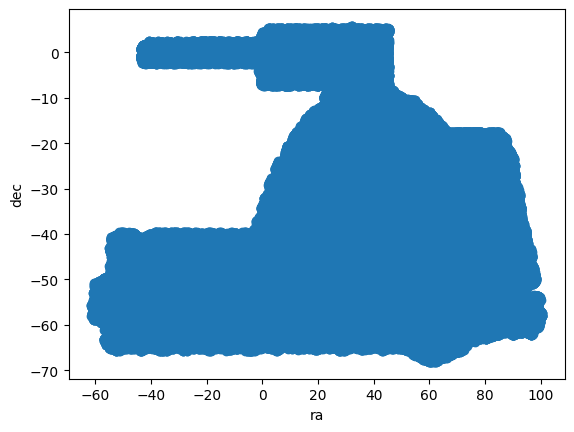

In [115]:
# visualizing the galaxies on the sky
plt.scatter(ra, dec)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()
plt.close()

# Data Processing

In [116]:
f_nu_list = []
err_fnu_list = []
ivar_list = []

for i in range(x):
    f_nu = 10**(-0.4*mag_list[i])        # 'dirty' appmags -> 'dirty' maggies
    f_nu_list.append(f_nu)

    # from std error propagation
    err_fnu = mag_err_list[i] * 0.4 * np.log(10) * 10**(-0.4*mag_list[i]) # from f_err**2 = |df/dm|**2 m_err**2, this is the standard deviation of the flux
    err_fnu_list.append(err_fnu)
    
    ivars = err_fnu**(-2)
    ivar_list.append(ivars)

# K correction

In [117]:
# getting k correction values
responses = ['decam_g','decam_r','decam_i','decam_z','decam_Y']
kz = kcorrect.kcorrect.Kcorrect(responses=responses, cosmo=cosmo)

maggies = f_nu_list
ivar = ivar_list    # inverse variance = (1/std.dev.)^2
redshift = phot_reds

coeffs = kz.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

K = kz.kcorrect(redshift=redshift, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

derived = kz.derived(redshift=redshift, coeffs=coeffs)
sm = derived['mremain']

In [118]:
f_nu_list = []
err_fnu_list = []
ivar_list = []

In [119]:
M = []
for i in range(x):
    M_calc = mag_list[i] -DM[i] -K[i]
    M.append(M_calc)
M = np.array(M)

In [120]:
err_M = []
for i in range(x):
    M_calc_err = np.sqrt(mag_err_list[i]**2 + DM_err[i]**2)
    err_M.append(M_calc_err)
err_M = np.array(err_M)

In [121]:
mag_list = []
mag_err_list = []

Visualisation

In [122]:
M_g = np.array([row[0] for row in M])
M_r = np.array([row[1] for row in M])
M_i = np.array([row[2] for row in M])
M_z = np.array([row[3] for row in M])
M_y = np.array([row[4] for row in M])

In [123]:
err_M_g = np.array([row[0] for row in err_M])
err_M_r = np.array([row[1] for row in err_M])
err_M_i = np.array([row[2] for row in err_M])
err_M_z = np.array([row[3] for row in err_M])
err_M_y = np.array([row[4] for row in err_M])

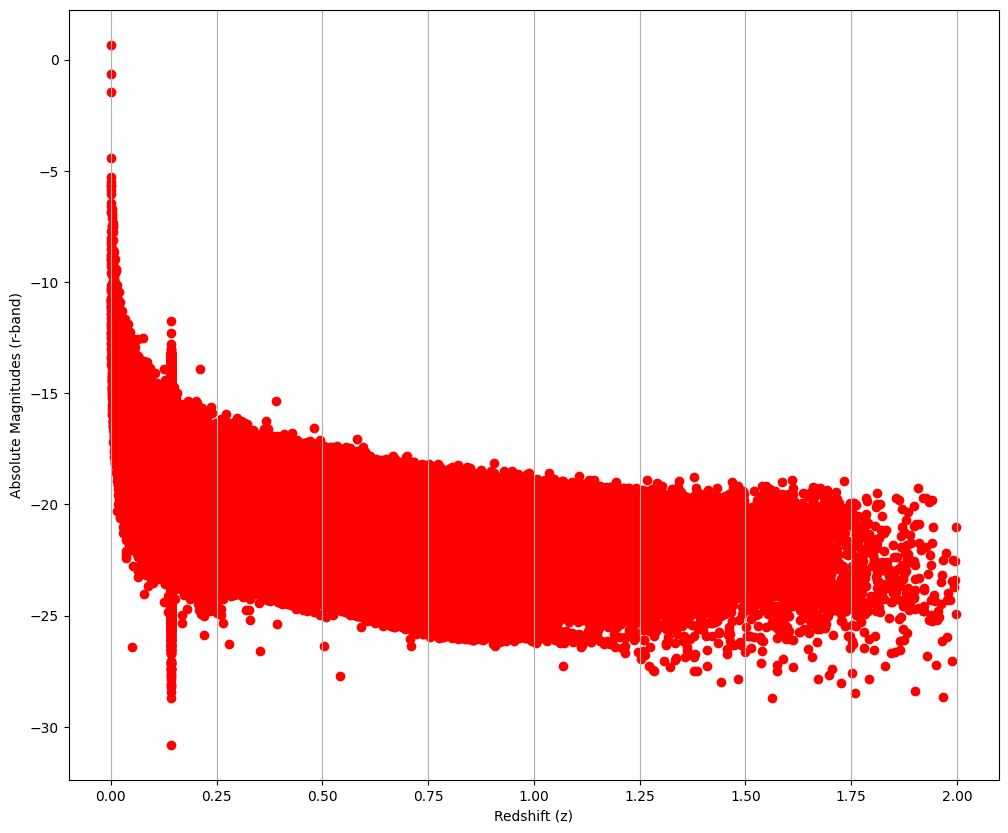

In [124]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, M_r, marker="o", c='r')

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

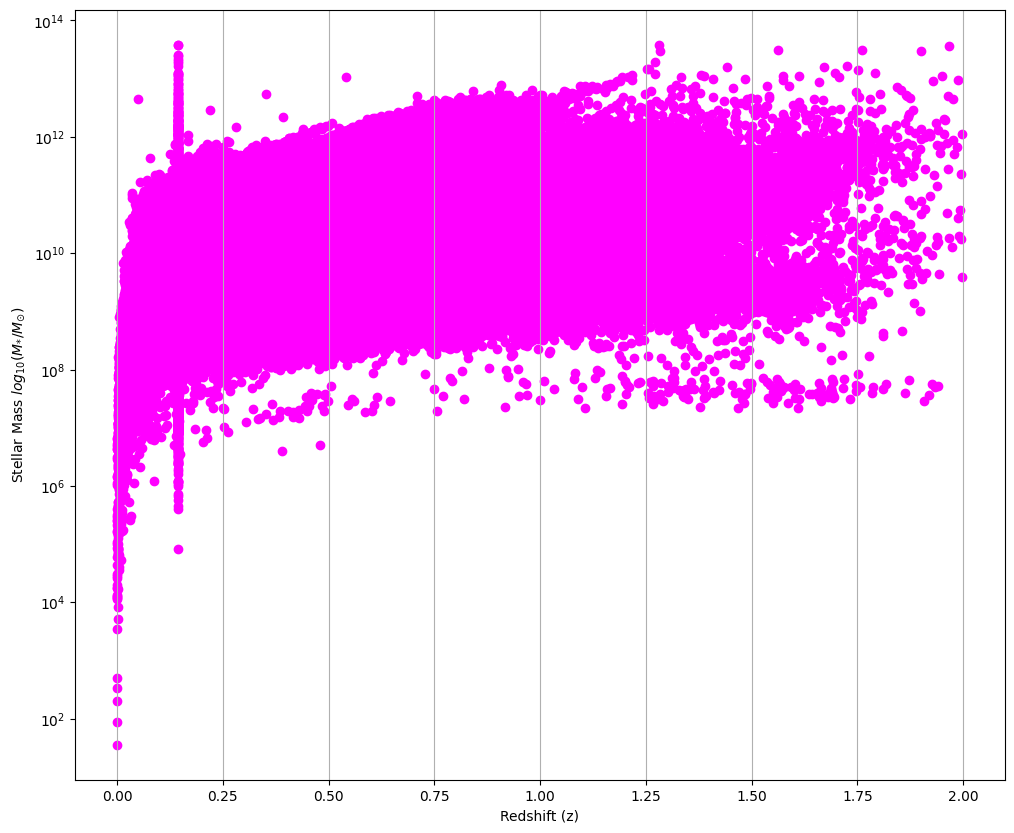

In [125]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, sm, marker='o', c='fuchsia')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

Data Saving

In [126]:
neofits = fitsio.FITS('/home/ygence/scratch/DES_Y3_1M_lowerr.fits','rw')
arr_list = [phot_reds, phot_reds_err, M_g, err_M_g, M_r, err_M_r, M_i, err_M_i, M_z, err_M_z, M_y, err_M_y, sm, ra, dec]
names = ['z','z_err','M_g','M_err_g','M_r','M_err_r','M_i','M_err_i','M_z','M_err_z','M_y','M_err_y','SM','ra','dec']
#neofits.write(arr_list, names=names)
neofits[-1].append(arr_list,names=names)
neofits.close()

# Schechter Form of the Luminosity Function

In [1]:
%reset -f

In [2]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

sch_c = 3e5 * u.km/u.s
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [3]:
fitsio.read_header('/home/ygence/scratch/DES_Y3_1M_lowerr.fits',ext=1)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  112 / width of table in bytes
NAXIS2  =              2527800 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   15 / number of fields in each row
TTYPE1  = 'z'                  / label for field   1
TFORM1  = 'E'                  / data format of field: 4-byte REAL
TTYPE2  = 'z_err'              / label for field   2
TFORM2  = 'E'                  / data format of field: 4-byte REAL
TTYPE3  = 'M_g'                / label for field   3
TFORM3  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE4  = 'M_err_g'            / label for field   4
TFORM4  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE5  = 'M_r'                / label for field   5

In [4]:
fits = fitsio.read('/home/ygence/scratch/DES_Y3_1M_lowerr.fits', rows=range(1000000), ext=1)

In [5]:
maskMl = fits['M_r'] > (-30)
maskMh = fits['M_r'] < (-10)
maskz = fits['z'] < 0.5
maskM = maskMl & maskMh & maskz
fits = fits[maskM]

In [6]:
ra = fits['ra']
dec = fits['dec']

schM = fits['M_r']
schM_err = fits['M_err_r']
schM_l = schM.min()
schM_u = schM.max()

sch_z = fits['z']
sch_z_err = fits['z_err']
sch_z_max = sch_z.max()

sch_dl = cosmo.luminosity_distance(sch_z)

In [7]:
X = np.array([ra,dec]).T

cellno = int(len(X)/2500) # should be 400 for test run

In [8]:
'''# run no more than 100 iterations. Will stop if tolerance is met
km = kr.kmeans_sample(X, cellno, maxiter=100, tol=1.0e-5)

# we got back a KMeans object:

# the centers found by the algorithm
print("found centers:",km.centers)

# did we converge?
print("converged?",km.converged)

# labels are the index to the nearest center for each point in X
print("labels size:",km.labels.size)

# how many in each cluster? Should be fairly uniform
print("cluster sizes:", np.bincount(km.labels))

# the distance to each center [Npoints, Ncen]
print("shape of distances:",km.distances.shape)'''


'# run no more than 100 iterations. Will stop if tolerance is met\nkm = kr.kmeans_sample(X, cellno, maxiter=100, tol=1.0e-5)\n\n# we got back a KMeans object:\n\n# the centers found by the algorithm\nprint("found centers:",km.centers)\n\n# did we converge?\nprint("converged?",km.converged)\n\n# labels are the index to the nearest center for each point in X\nprint("labels size:",km.labels.size)\n\n# how many in each cluster? Should be fairly uniform\nprint("cluster sizes:", np.bincount(km.labels))\n\n# the distance to each center [Npoints, Ncen]\nprint("shape of distances:",km.distances.shape)'

In [9]:
'''cell_list = [[] for _ in range(cellno)]
num = np.arange(0,cellno)
eventno = len(sch_z)

for i in np.arange(0,eventno):
    cell_list[km.labels[i]].append(i)
'''

'cell_list = [[] for _ in range(cellno)]\nnum = np.arange(0,cellno)\neventno = len(sch_z)\n\nfor i in np.arange(0,eventno):\n    cell_list[km.labels[i]].append(i)\n'

Defining the the comoving volume function (Eales 1993)

In [10]:
def V(x):
    return ((1+x)**2 * np.sqrt(cosmo.Ode0 + cosmo.Om0 * (1+x)**3))**(-1)

survey_area = 5000
integ,_ = sp.integrate.quad(lambda x:V(x), 0,sch_z_max)
V_max = np.array(survey_area*sch_c*sch_dl**2/cosmo.H0 * integ /u.Mpc**3)   # defining Vmax

<Axes: >

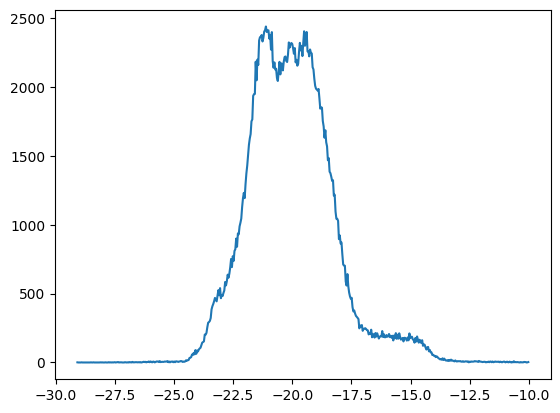

In [11]:
counts,edges = np.histogram(schM, bins=int(np.sqrt(len(schM)))) # binning the absolute mags
optedges = 0.5*(edges[1:]+edges[:-1])
s=pd.Series(counts,index=optedges)
s.plot()

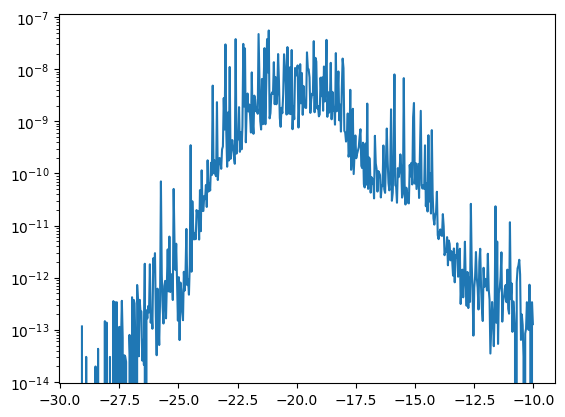

In [12]:
sumIV_max_binned = np.zeros(len(counts))    # 1/Vmax summation based on the absmag bins

prevEnd = 0

for idx, count in enumerate(counts):
    V_max_for_count = V_max[prevEnd:prevEnd+count]
    sumIV_max_binned[idx] = np.sum(1/V_max_for_count)

    prevEnd = prevEnd + count

plt.plot(optedges, sumIV_max_binned)
plt.yscale('log')

Defining the Schechter function

In [13]:
from scipy.optimize import curve_fit

#single
def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

#double
def doubfunc(x, M_star, alpha1, phi1, alpha2, phi2):
    return 0.4*np.log(10)*(phi1*10**(-0.4*(1+alpha1)*(x-M_star))+phi2*10**(-0.4*(1+alpha2)*(x-M_star)))*np.exp(-1*(10)**(-0.4*(x-M_star)))

In [14]:
#fit_sel = (optedges > -33) & (optedges < -20.1)       # masking for bad data

coeffs, cov = curve_fit(func, optedges, sumIV_max_binned, p0=[-22,-2,1]) #fitting the Schechter function

stddev = np.sqrt(cov) #recovering the std. dev.

stddiag = [-stddev[0,0],-stddev[1,1],stddev[2,2]] # to keep the error bar lines consistent

coeffs, cov

(array([-2.17659388e+01, -4.45468688e-01,  2.33992508e-08]),
 array([[5.08745199e-02, 1.65569471e-02, 4.27599362e-10],
        [1.65569471e-02, 8.45902616e-03, 2.18461219e-10],
        [4.27599362e-10, 2.18461219e-10, 8.02116909e-18]]))

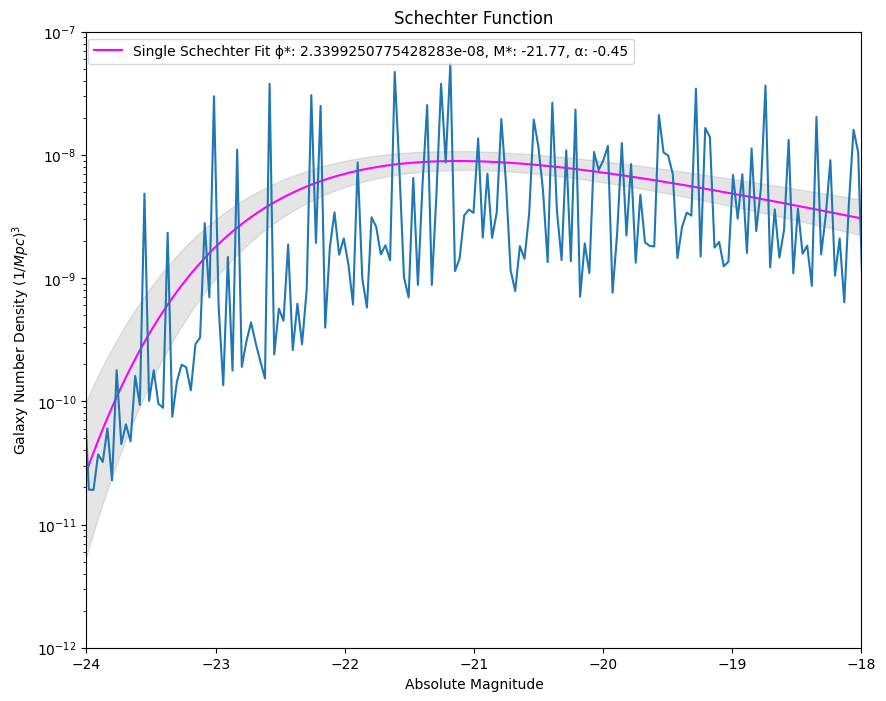

In [15]:
fig, ax = plt.subplots()
ax.plot(optedges, func(optedges,*coeffs), color='fuchsia', label=[f'Single Schechter Fit ϕ*: {coeffs[2]}, M*: {coeffs[0]:.2f}, α: {coeffs[1]:.2f}'])
ax.fill_between(optedges,func(optedges,*(coeffs+stddiag)), func(optedges,*(coeffs-stddiag)), alpha=0.2 ,where=(func(optedges,*(coeffs+stddiag))>func(optedges,*(coeffs-stddiag))), color='grey')
ax.plot(optedges, sumIV_max_binned)
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel(r'Galaxy Number Density $(1/Mpc)^{3}$')
ax.set_title('Schechter Function')
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xbound(-24,-18)           #enable to see a close-up
ax.set_ybound(1e-12,1e-7)
fig.set_size_inches(10,8)
fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
plt.show()